# Imports

In [1]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

import eaopack as eao
from eaopack.portfolio import Portfolio
from eaopack.basic_classes import Timegrid
from eaopack.optimization import Results

# Defining a portfolio

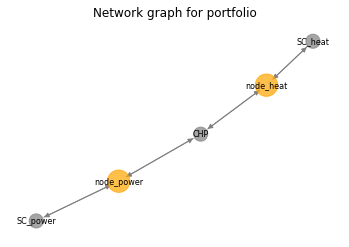

In [2]:
node_power = eao.assets.Node('node_power')
node_heat = eao.assets.Node('node_heat')

timegrid = eao.assets.Timegrid(dt.date(2021, 1, 1), dt.date(2021, 1, 2), freq='h', main_time_unit='h')
simple_contract1 = eao.assets.SimpleContract(name='SC_power', price='price_power', nodes=node_power,
                                            min_cap=-30., max_cap=20)
simple_contract2 = eao.assets.SimpleContract(name='SC_heat', price='price_heat', nodes=node_heat,
                                            min_cap=-30., max_cap=20.)

chpasset = eao.assets.CHPAsset(name='CHP', 
                                     nodes=[node_power, node_heat],
                                     min_cap=10., 
                                     max_cap=30.,
                                     extra_costs=0,
                                     freq='h',
                                     conversion_factor_power_heat=0.5, 
                                     max_share_heat=0.5,
                                     ramp=20, 
                                     start_costs=0.1, 
                                     running_costs=0., 
                                     min_runtime=2., 
                                     time_already_running=0., 
                                     last_dispatch=0.)

prices = {'price_power': np.sin(0.5*np.pi * np.arange(timegrid.T)*np.pi/10),
          'price_heat': np.cos(0.5*np.pi * np.arange(timegrid.T)*np.pi/10), 
          }

portfolio = eao.portfolio.Portfolio([chpasset, simple_contract1, simple_contract2])
eao.network_graphs.create_graph(portf = portfolio)

# Performing the Optimization

In [3]:
op = portfolio.setup_optim_problem(prices, timegrid)
res = op.optimize(solver="GLPK_MI")
out = eao.io.extract_output(portfolio, op, res, prices)
out['summary']

...MIP problem configured. Beware of potentially long optimization and other issues inherent to MIP


,Values
Parameter,
status,successful
value,276.054299


# Plotting the Results

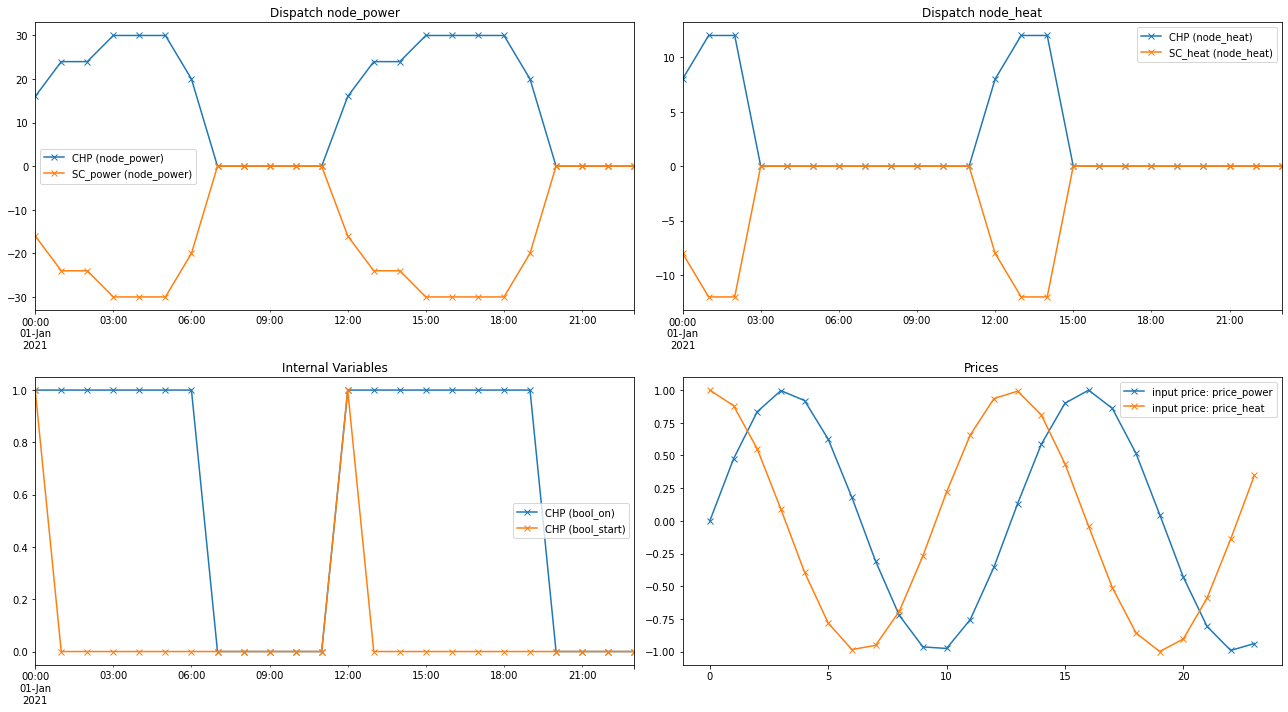

In [4]:
# Define the grid size to display the figures:
num_imgs_per_row = 2
num_nodes = len(portfolio.nodes)
num_img_rows=int(np.ceil((num_nodes+2)/num_imgs_per_row))
fig, ax = plt.subplots(num_img_rows, num_imgs_per_row, tight_layout = True, figsize=(18,5*num_img_rows))
ax = ax.reshape(-1)

# Plot the dispatch for each node:
current_ax=0
dispatch_per_node = {node: [] for node in portfolio.nodes}
for mycol in out['dispatch'].columns.values:
    for node in dispatch_per_node:
        if '(' + node + ')' in mycol:
            dispatch_per_node[node].append(mycol)
for node in dispatch_per_node:
    out['dispatch'][dispatch_per_node[node]].plot(ax=ax[current_ax], style='-x')
    ax[current_ax].set_title("Dispatch " + node)
    current_ax+=1

# Plot internal variables:
for v in out['internal_variables']:
    out['internal_variables'][v].plot(ax=ax[current_ax], style='-x', label=v)
ax[current_ax].set_title('Internal Variables')
ax[current_ax].legend()
current_ax+=1

# Plot prices
for key in out['prices']:
    out['prices'][key].plot(ax=ax[current_ax], style='-x', label=key)
ax[current_ax].set_title('Prices')
ax[current_ax].legend()

# Remove empty axes:
for i in range(current_ax+1, len(ax)):
    fig.delaxes(ax[i])